# Simulate SLD distribution and R(Q)

In [2]:
import sys
import os
import numpy as np
np.random.seed(42)

import json
import tensorflow as tf

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')


In [48]:
# Directory in which the code sits
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'vae-sld')

#config_file = os.path.join(git_dir, 'scripts', 'config-a_si-air.json')
config_file = os.path.join(git_dir, 'scripts', 'config-cell-b.json')
#config_file = os.path.join(git_dir, 'scripts', 'config-erik.json')
with open(config_file, 'r') as fd:
    config = json.load(fd)

data_dir = config['data_dir']
train_dir = config['train_dir']
model_name = config['name']
print("Training dir: %s" % train_dir)

# Add source to path
sys.path.append(config['src_dir'])
sys.path.append(os.path.join(config['src_dir'], 'src'))

import reflectivity_model
import network
import importlib

importlib.reload(network)

Training dir: /Users/m2d/git/vae-sld/data/cell_b/training_data_fix


<module 'network' from '/Users/m2d/git/vae-sld/src/network.py'>

In [64]:
importlib.reload(reflectivity_model)

with open(config_file, 'r') as fd:
    config = json.load(fd)

m = reflectivity_model.ReflectivityModels(q=None, name=config['name'],
                                          max_thickness=config['max_thick'],
                                          dz=config['dz'],
                                          fix_first_n=config['fix_first_n'])

m.model_description = config['model']
m.parameters = config['parameters']

m.generate(10)

if config['use_errors']:
    ref_data = np.loadtxt(config['data_ref']).T
    _err = ref_data[2] / ref_data[1]
    errors = np.interp(m.q, ref_data[0], _err)
    train_pars, train_data = m.get_preprocessed_data(errors=errors)
else:
    train_pars, train_data = m.get_preprocessed_data()

print(train_pars[0].shape, train_data[0].shape)

train_pars = m.process_predictions(train_pars)
i_test = 0

Computing reflectivity
FIX: 100
(10, 300)
(300,) (150,)


# Get the training data in R(Q) and retrieve the error

Item: 1


<IPython.core.display.Javascript object>


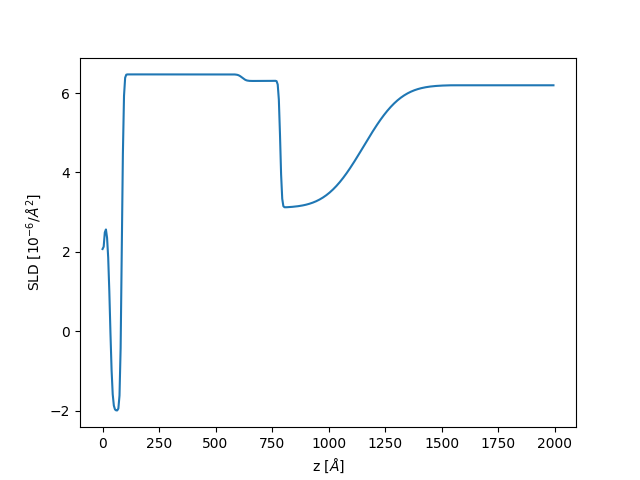

<IPython.core.display.Javascript object>


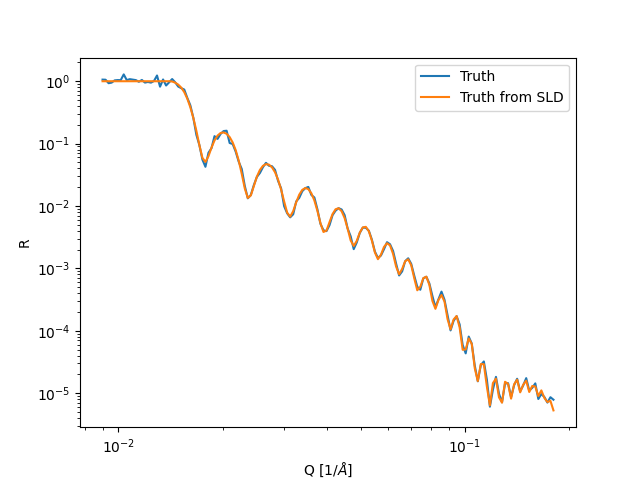

In [65]:
importlib.reload(reflectivity_model)

i_test +=1

print("Item: %s" % i_test)

#z = np.arange(config_val['z_left'], config_val['z_right']+config_val['dz'], config_val['dz'])
z = np.arange(0, config['dz']*len(train_pars[i_test]), config['dz'])


fig = plt.figure(dpi=100)
plt.plot(z, train_pars[i_test], label="Truth")
#plt.gca().legend()
plt.xlabel('z [$\AA$]')
plt.ylabel('SLD [$10^{-6}/\AA^2$]')
plt.show()


r_true_sld = reflectivity_model.calculate_reflectivity_from_profile(m.q, z, train_pars[i_test])
r_true = np.power(10, train_data[i_test])*m.q[0]**2/m.q**2


fig = plt.figure(dpi=100)
plt.plot(m.q, r_true, label="Truth")
plt.plot(m.q, r_true_sld, label="Truth from SLD")

plt.gca().legend()
plt.xlabel('Q [$1/\AA$]')
plt.ylabel('R')
plt.xscale('log')
plt.yscale('log')
plt.show()



<IPython.core.display.Javascript object>


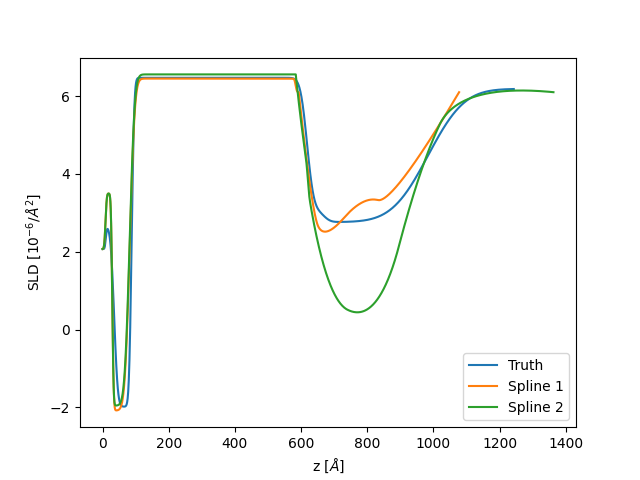

<IPython.core.display.Javascript object>


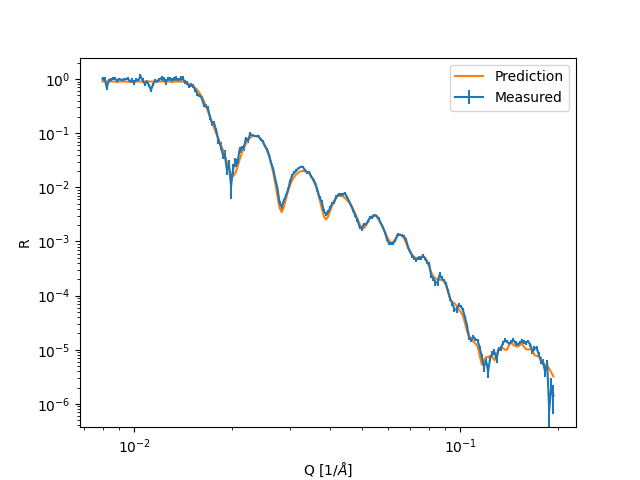

In [13]:
spline_dir = os.path.join(git_dir, "data", "splines")

sld_fit = np.loadtxt(os.path.expanduser("~/git/vae-sld/data/201282-profile.dat")).T
d = np.loadtxt(os.path.expanduser("~/git/vae-sld/data/REFL_201282_reduced_data.txt")).T
scale = 1.

scale = 1.05
sld_fit = np.loadtxt(os.path.expanduser("~/git/vae-sld/data/201298-profile.dat")).T
d = np.loadtxt(os.path.expanduser("~/git/vae-sld/data/REFL_201298_reduced_data.txt")).T

sld_fit = np.loadtxt(os.path.expanduser("~/git/vae-sld/data/201306-profile.dat")).T
d = np.loadtxt(os.path.expanduser("~/git/vae-sld/data/REFL_201306_reduced_data.txt")).T
spline_sld_1 = np.loadtxt(os.path.join(spline_dir, "201306_subfix_6cp_SLD.dat")).T
spline_sld_2 = np.loadtxt(os.path.join(spline_dir, "201306_subfix_6cp_low_SLD.dat")).T
spline_fit_1 = np.loadtxt(os.path.join(spline_dir, "201306_subfix_6cp_FIT.dat")).T
spline_fit_2 = np.loadtxt(os.path.join(spline_dir, "201306_subfix_6cp_low_FIT.dat")).T

#scale = 1
#sld_fit = np.loadtxt(os.path.expanduser("~/git/vae-sld/data/201290-profile.dat")).T
#d = np.loadtxt(os.path.expanduser("~/git/vae-sld/data/REFL_201290_reduced_data.txt")).T



fig = plt.figure(dpi=100)
plt.plot(sld_fit[0][-1]-sld_fit[0], sld_fit[1], label="Truth")
plt.plot(-spline_sld_1[0][0]+spline_sld_1[0], spline_sld_1[1], label="Spline 1")
plt.plot(-spline_sld_2[0][0]+spline_sld_2[0], spline_sld_2[1], label="Spline 2")


plt.gca().legend()
plt.xlabel('z [$\AA$]')
plt.ylabel('SLD [$10^{-6}/\AA^2$]')
plt.show()


fig = plt.figure(dpi=100)
plt.errorbar(d[0], scale * d[1], yerr=scale*d[2], label="Measured")
plt.plot(spline_fit_1[0], spline_fit_1[1], label="Spline 1")
plt.plot(spline_fit_2[0], spline_fit_2[1], label="Spline 2")

plt.gca().legend()
plt.xlabel('Q [$1/\AA$]')
plt.ylabel('R')
plt.xscale('log')
plt.yscale('log')
plt.show()
